## Homework 4: Neural Networks

**Due date:** May 2, 2021

The goal of the assignment is to train a simple neural network on MNIST data.

*Note:* This notebook requires Python 3.

**Instructions:**

* Read and understand the provided code, which is a basic implementation of a neural network as a modular architecture.
* Download the [MNIST data](http://deeplearning.net/data/mnist/mnist.pkl.gz) (~15Mo). It consists of 28x28 images (loaded as a 784 vector) and the associated labels for training, validation and test sets. For this homework, you will only use the training and validation sets. 
* Write a simple loop to train 50 iterations of the implemented MLP (multi-layer perceptron) with a learning rate 0.001 and batches of size 16. Plot the training and validation losses throughout the training process (you don't have to test your network at every iteration, you can do it for example every 10 iterations).
* Evaluate the accuracy of your trained model on the training and validation data. Check the predictions on random validation images.
* Try changing learning rate and batch size and see if you can improve your results.
* How many parameters does the network have? Implement and experiment with some variations of the architecture, for example:
    * Implement and use the cross-entropy loss instead of L2 loss.
    * Add a parameter to vary the size of the intermediate layer.
    * Use a MLP with 3 layers and parameters for the sizes of the two intermediate layers.


## MLP implementation

In [55]:
import numpy as np 
import math
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['image.cmap'] = 'gray' 
import gzip
import pickle
import tqdm.notebook as tqdm

class Module(object):
    def __init__(self):
        self.gradInput=None 
        self.output=None
        
    def forward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x,labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batchSize,in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x):
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self,lr):
        self.weight=self.weight-lr*self.gradWeight
        self.bias=self.bias-lr*self.gradBias
        

class ReLU(Module):
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput
    
        

class MLP(Module):

    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

## Load and visualize the dataset

5


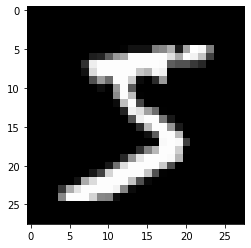

In [24]:
path = 'mnist/' # where you saved the dataset
f = gzip.open(path + 'mnist.pkl.gz', 'rb') 
train_set, val_set, test_set = pickle.load(f, encoding='latin1')
f.close()
train_data = train_set[0]
train_labels = train_set[1]
val_data = val_set[0]
val_labels = val_set[1]
N_train = train_data.shape[0]
N_val = val_data.shape[0]
# check that the data makes sense
plt.imshow(train_data[0, :].reshape(28, 28))
print(train_labels[0])

In [48]:
LR = 0.001
BATCH_SIZE = 16
NUM_ITERATION = 50

In [27]:
train_data = np.array_split(train_data, train_data.shape[0] // BATCH_SIZE)
train_labels = np.array_split(train_labels, train_labels.shape[0] // BATCH_SIZE)
val_data = np.array_split(val_data, val_data.shape[0] // BATCH_SIZE)
val_labels = np.array_split(val_labels, val_labels.shape[0] // BATCH_SIZE)

In [61]:
model = MLP()
ls_loss = LeastSquareCriterion()

train_losses = []
val_losses = []

for t in tqdm.tqdm(range(NUM_ITERATION)):
    for batch, images in enumerate(train_data):
        labels = train_labels[batch]
        out = model.forward(images)
        loss = ls_loss.forward(out, labels)
        ls_loss.backward(out, labels)
        model.backward(images, ls_loss.gradInput)
        model.gradientStep(LR)
    train_losses.append(loss)
    loss = 0.0
    for batch, images in enumerate(val_data):
        labels = val_labels[batch]
        out = model.forward(images)
        loss += ls_loss.forward(out, labels)
    val_losses.append(loss/len(val_data))  

Text(0, 0.5, 'loss per batch')

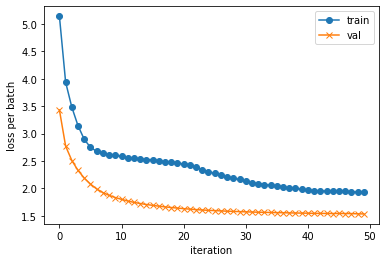

In [68]:
plt.plot(train_losses, "o-", label="train")
plt.plot(val_losses, "-x", label="val")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("loss per batch")

## compute accuracy on train and val sets

In [80]:
def compute_accuracy(model, data, labels):
    correct = 0.0
    total = 0.0

    for batch, images in enumerate(data):
        targets = labels[batch]
        out = model.forward(images)
        predictions = out.argmax(axis=1)
        total += len(predictions)
        correct += sum(targets == predictions)
        
    print("accuracy:", correct/total)

In [81]:
compute_accuracy(model, train_data, train_labels)

accuracy: 0.9771


In [82]:
compute_accuracy(model, val_data, val_labels)

accuracy: 0.9694


## check predictions on random val images

In [87]:
random_indices = np.random.choice(len(val_data), 3, replace=False)

prediction: 0 target: 0
prediction: 6 target: 6
prediction: 2 target: 2


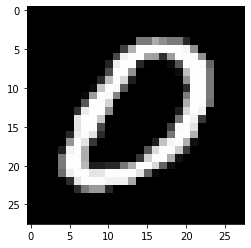

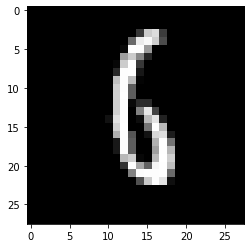

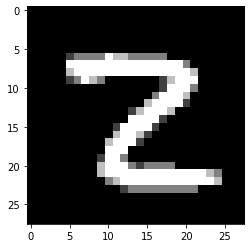

In [90]:
for batch in random_indices:
    images = val_data[batch]
    prediction = model.forward(images)[0].argmax()
    target = val_labels[batch][0]
    print("prediction:", prediction, "target:", target)
    plt.figure()
    plt.imshow(images[0].reshape(28, 28))

In [99]:
print("the model has", model.fc1.weight.size + model.fc1.bias.size + model.fc2.weight.size + model.fc2.bias.size, "parameters")

the model has 50890 parameters


## check learning rate and batch size

In [100]:
LR = 0.01
BATCH_SIZE = 64
NUM_ITERATION = 50

In [102]:
path = 'mnist/' # where you saved the dataset
f = gzip.open(path + 'mnist.pkl.gz', 'rb') 
train_set, val_set, test_set = pickle.load(f, encoding='latin1')
f.close()
train_data = train_set[0]
train_labels = train_set[1]
val_data = val_set[0]
val_labels = val_set[1]
N_train = train_data.shape[0]
N_val = val_data.shape[0]

In [103]:
train_data = np.array_split(train_data, train_data.shape[0] // BATCH_SIZE)
train_labels = np.array_split(train_labels, train_labels.shape[0] // BATCH_SIZE)
val_data = np.array_split(val_data, val_data.shape[0] // BATCH_SIZE)
val_labels = np.array_split(val_labels, val_labels.shape[0] // BATCH_SIZE)

In [104]:
model = MLP()
ls_loss = LeastSquareCriterion()

train_losses = []
val_losses = []

for t in tqdm.tqdm(range(NUM_ITERATION)):
    for batch, images in enumerate(train_data):
        labels = train_labels[batch]
        out = model.forward(images)
        loss = ls_loss.forward(out, labels)
        ls_loss.backward(out, labels)
        model.backward(images, ls_loss.gradInput)
        model.gradientStep(LR)
    train_losses.append(loss)
    loss = 0.0
    for batch, images in enumerate(val_data):
        labels = val_labels[batch]
        out = model.forward(images)
        loss += ls_loss.forward(out, labels)
    val_losses.append(loss/len(val_data))  

### checking batch size or learning rate does not improve the accuracy 

In [105]:
compute_accuracy(model, train_data, train_labels)

accuracy: 0.9752


In [106]:
compute_accuracy(model, val_data, val_labels)

accuracy: 0.964


## Add a third layer for MLP and vary the size of the two intermediate layers

In [107]:
class MLP(Module):

    def __init__(self, layer_sizes=[64, 32], num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, layer_sizes[0])
        self.relu1 = ReLU()
        self.fc2 = Linear(layer_sizes[0], layer_sizes[1])
        self.relu2 = ReLU()
        self.fc3 = Linear(layer_sizes[1], num_classes)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.relu2.output,gradient)
        gradient = self.relu2.backward(self.fc2.output,gradient)
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr):
        self.fc3.gradientStep(lr)
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

In [108]:
model = MLP(layer_sizes=[64, 32])
ls_loss = LeastSquareCriterion()

train_losses = []
val_losses = []

for t in tqdm.tqdm(range(NUM_ITERATION)):
    for batch, images in enumerate(train_data):
        labels = train_labels[batch]
        out = model.forward(images)
        loss = ls_loss.forward(out, labels)
        ls_loss.backward(out, labels)
        model.backward(images, ls_loss.gradInput)
        model.gradientStep(LR)
    train_losses.append(loss)
    loss = 0.0
    for batch, images in enumerate(val_data):
        labels = val_labels[batch]
        out = model.forward(images)
        loss += ls_loss.forward(out, labels)
    val_losses.append(loss/len(val_data))  
    
compute_accuracy(model, val_data, val_labels)


accuracy: 0.9731


In [109]:
model = MLP(layer_sizes=[128, 64])
ls_loss = LeastSquareCriterion()

train_losses = []
val_losses = []

for t in tqdm.tqdm(range(NUM_ITERATION)):
    for batch, images in enumerate(train_data):
        labels = train_labels[batch]
        out = model.forward(images)
        loss = ls_loss.forward(out, labels)
        ls_loss.backward(out, labels)
        model.backward(images, ls_loss.gradInput)
        model.gradientStep(LR)
    train_losses.append(loss)
    loss = 0.0
    for batch, images in enumerate(val_data):
        labels = val_labels[batch]
        out = model.forward(images)
        loss += ls_loss.forward(out, labels)
    val_losses.append(loss/len(val_data))  
    
compute_accuracy(model, val_data, val_labels)


accuracy: 0.9784


**As we can see, adding more layers and using a bigger network improved our accuracy by a bit, however, since we are doing already pretty well on this dataset, using such a big network may be an overkill.**